# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
# If the package geopandas isnt installed on your python enviroment, 
# you can do it using the below code:
#conda install geopandas

# it can take a couple of minutes....

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read and clean data

Import your data, either through an API or manually, and load it. 

The geojson file is imported

In [2]:
#import json
#mun_data = json.loads("kommuner.geojson")
#mun_data['features'][0]['geometry'] #Your first point


import geopandas as gpd
mun_data = gpd.read_file('kommuner.geojson')
print(mun_data.head())


  KOMKODE     KOMNAVN                                           geometry
0    0766   Hedensted  POLYGON Z ((9.44919 55.86046 -999.00000, 9.460...
1    0766   Hedensted  POLYGON Z ((10.06198 55.83301 -999.00000, 10.0...
2    0561     Esbjerg  POLYGON Z ((8.59656 55.53506 -999.00000, 8.601...
3    0849  Jammerbugt  POLYGON Z ((9.78314 57.07319 -999.00000, 9.781...
4    0849  Jammerbugt  POLYGON Z ((9.19738 57.13868 -999.00000, 9.207...


DST data

In [61]:
import pydst
dst = pydst.Dst(lang='en')

# GALDER
galder = dst.get_data(table_id = 'GALDER', variables={'KOMK':['*'], 'KØN':['*'], 'TID':['*']})
#galder.head()


# FLY66 flytninger mellem kommuner
fly = dst.get_data(table_id = 'FLY66', variables={'TILKOMMUNE':['*'], 'FRAKOMMUNE':['*'], 'ALDER':['*'], 'KØN':['*'], 'TID':['*']})
#fly.head(5)

In [100]:
# renameing the municipality variables
fly['TILKOMMUNE'] = fly['TILKOMMUNE'].str.replace(r'To ', '')
fly['FRAKOMMUNE'] = fly['FRAKOMMUNE'].str.replace(r'From ', '')

# I find the sum of people moving for every municipality pair and year.
fly_sum = fly.groupby(['TILKOMMUNE','FRAKOMMUNE'], as_index=False)['INDHOLD'].sum()

# med tid
# fly_sum = fly.groupby(['TILKOMMUNE','FRAKOMMUNE','TID'], as_index=False)['INDHOLD'].sum()

fly_sum.head(5)

,TILKOMMUNE,FRAKOMMUNE,INDHOLD
0,Aabenraa,Aalborg,549
1,Aabenraa,Aarhus,2327
2,Aabenraa,Albertslund,55
3,Aabenraa,Allerød,24
4,Aabenraa,Assens,243


In [67]:
print(fly_sum['Aabenraa', 'Aalborg', 2006])

38


In [47]:
# Excluding non municipality observations
I  = galder.KOMK.str.contains('Region')
I |= galder.KOMK.str.contains('All')
galder.loc[I, :]
galder = galder.loc[I == False] # keep everything else

# excluding the seperat rows for men and women, only keeping the total.
J = galder.KØN.str.contains('Total')
galder.loc[J, :]
galder = galder.loc[J == True] # keep everything else

# wont need the KØN column once ive restricted the data set to only contain the total.
galder.drop(columns=['KØN'], inplace=True)

galder.head(5)

,KOMK,TID,INDHOLD
20,Copenhagen,2019,36.0
23,Frederiksberg,2019,39.8
26,Ballerup,2019,42.2
29,Brøndby,2019,41.5
32,Dragør,2019,44.4


In [ ]:
galder_sum = galder.groupby(['KOMK','TID'])['INDHOLD'].sum()

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

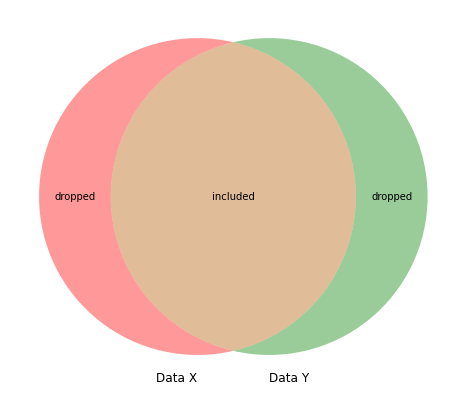

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

In [90]:
fly_sum.head(2)

Aa = fly_sum.TILKOMMUNE.str.contains('Aabenraa')
fly_sum.loc[Aa, :]
Aabenraa = fly_sum.loc[Aa == True] # keep everything else
Aabenraa_2020 = Aabenraa.loc[Aabenraa['TID']== 2020]
Aabenraa_2020.rename(columns={"FRAKOMMUNE": "KOMNAVN"},inplace=True)

Aabenraa_2020.head(2)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_11928\2545569834.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,TILKOMMUNE,KOMNAVN,TID,INDHOLD
14,Aabenraa,Aalborg,2020,34
31,Aabenraa,Aarhus,2020,181


Merge aabenra data med geopandas

In [95]:
Aa_geo = pd.merge(mun_data, Aabenraa_2020, on=['KOMNAVN'],how='outer')
Aa_geo.head(1)

,KOMKODE,KOMNAVN,geometry,TILKOMMUNE,TID,INDHOLD
0,0766,Hedensted,"POLYGON Z ((9.44919 55.86046 -999.00000, 9.460...",Aabenraa,2020.0,10.0


(7.721258121284378, 15.511221766025908, 54.39942324562388, 57.911340690863874)

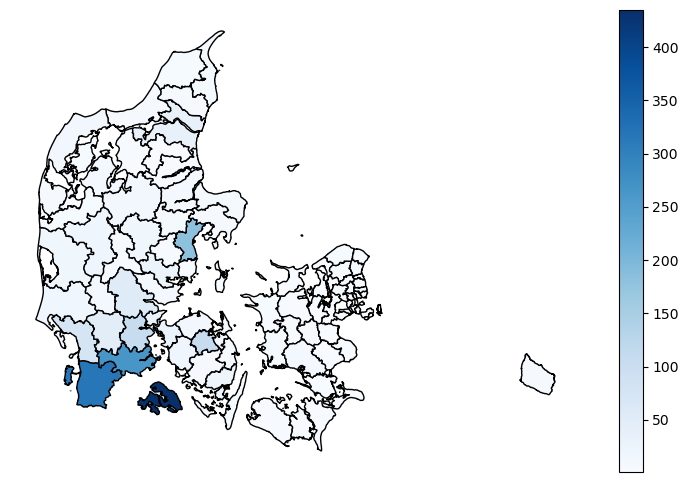

In [99]:
fig, ax = plt.subplots(1, figsize=(10,6))
Aa_geo.plot(column='INDHOLD', cmap='Blues', linewidth=1, ax=ax, edgecolor='0', legend = True)
ax.axis('off')

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.